In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import cohen_kappa_score

In [2]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../input/diabetic-retinopathy-2015-data-colored-resized/trainLabels.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['level'].map(diagnosis_dict_binary.get)
df['type'] = df['level'].map(diagnosis_dict.get)
df.head()

,image,level,binary_type,type
0,10_left,0,No_DR,No_DR
1,10_right,0,No_DR,No_DR
2,13_left,0,No_DR,No_DR
3,13_right,0,No_DR,No_DR
4,15_left,1,DR,Mild


<AxesSubplot:>

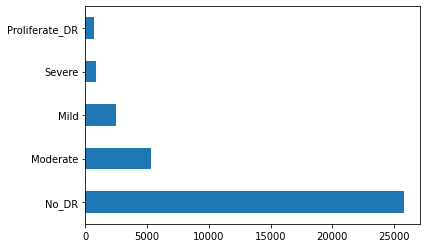

In [3]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

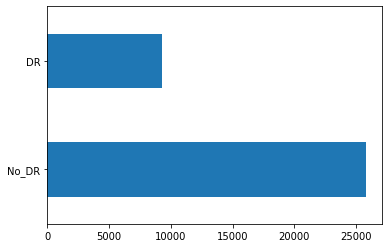

In [4]:
df['binary_type'].value_counts().plot(kind='barh')

In [5]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


No_DR             18067
Moderate           3704
Mild               1710
Severe              611
Proliferate_DR      496
Name: type, dtype: int64 

No_DR             3871
Moderate           794
Mild               367
Severe             131
Proliferate_DR     106
Name: type, dtype: int64 

No_DR             3872
Moderate           794
Mild               366
Severe             131
Proliferate_DR     106
Name: type, dtype: int64 



In [6]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [7]:
# Copy images to respective working directory
src_dir = r'../input/diabetic-retinopathy-2015-data-colored-resized/colored_images/colored_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['image'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [8]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 24588 images belonging to 2 classes.
Found 5269 images belonging to 2 classes.
Found 5269 images belonging to 2 classes.


### Custom CNN

In [9]:
# Building the model

cnn_model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
      
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = cnn_model.fit(train_batches,
                    epochs=15,
                    validation_data=val_batches)

2022-08-28 23:48:57.778002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 23:48:57.936829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 23:48:57.937684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 23:48:57.939612: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/15


2022-08-28 23:49:02.591274: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


769/769 [==============================] - 78s 92ms/step - loss: 0.5892 - acc: 0.7289 - val_loss: 0.5645 - val_acc: 0.7349
Epoch 2/15
769/769 [==============================] - 70s 92ms/step - loss: 0.5658 - acc: 0.7353 - val_loss: 0.5559 - val_acc: 0.7358
Epoch 3/15
769/769 [==============================] - 74s 96ms/step - loss: 0.5591 - acc: 0.7353 - val_loss: 0.5558 - val_acc: 0.7358
Epoch 4/15
769/769 [==============================] - 72s 94ms/step - loss: 0.5550 - acc: 0.7376 - val_loss: 0.5550 - val_acc: 0.7366
Epoch 5/15
769/769 [==============================] - 70s 90ms/step - loss: 0.5522 - acc: 0.7384 - val_loss: 0.5544 - val_acc: 0.7370
Epoch 6/15
769/769 [==============================] - 70s 91ms/step - loss: 0.5480 - acc: 0.7393 - val_loss: 0.5486 - val_acc: 0.7392
Epoch 7/15
769/769 [==============================] - 70s 90ms/step - loss: 0.5447 - acc: 0.7413 - val_loss: 0.5463 - val_acc: 0.7407
Epoch 8/15
769/769 [==============================] - 80s 103ms/step - lo

In [10]:
cnn_model.save('dissertation-CNN.model')

2022-08-29 00:08:02.381619: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [11]:
Y_pred=cnn_model.predict(test_batches)
y_pred = np.argmax(Y_pred, axis=1)

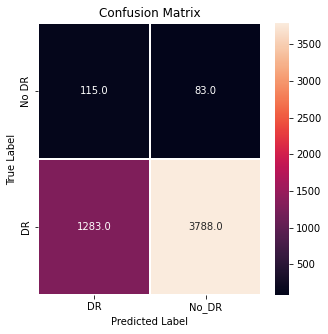

In [12]:
confusion_mtx = confusion_matrix(y_pred, test_batches.classes)
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
patient_labels = ['No DR','DR']
ax.yaxis.set_ticklabels(patient_labels)
plt.title("Confusion Matrix")
plt.show()

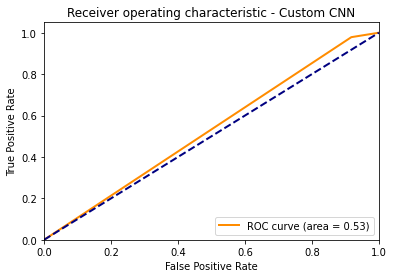

In [13]:
fpr = 0
tpr = 0
roc_auc = 0
fpr, tpr, _ = roc_curve(test_batches.classes, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic - Custom CNN")
plt.legend(loc="lower right")
plt.show()

In [14]:
print(classification_report(test_batches.classes, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.08      0.14      1398
           1       0.75      0.98      0.85      3871

    accuracy                           0.74      5269
   macro avg       0.66      0.53      0.50      5269
weighted avg       0.70      0.74      0.66      5269



In [15]:
loss, acc = cnn_model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc) 


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


165/165 [==============================] - 13s 77ms/step - loss: 0.5474 - acc: 0.7407
Accuracy:  0.7407477498054504


In [16]:
print('Custom CNN Cohen Kappas Value: ' + str(cohen_kappa_score(test_batches.classes, y_pred, labels=None, weights=None)))

Custom CNN Cohen Kappas Value: 0.08379401699348599


### VGG16

In [17]:
# Building the model

vgg16_model = tf.keras.Sequential([
  layers.Conv2D(64, (3,3), padding="same", input_shape=(224,224,3), activation = 'relu'),
    
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPool2D(2, strides=2, padding='same'),

  layers.Conv2D(28, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPool2D(2, strides=2, padding='same'),

  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPool2D(2, strides=2, padding='same'),

  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
 layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPool2D(2, strides=2, padding='same'),

  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
 layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPool2D(2, strides=2, padding='same'),
  layers.Flatten(),
  layers.Dense(4096, activation='relu'),
  layers.Dense(4096, activation='relu'),

  layers.Dense(2, activation='softmax')
])

vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = vgg16_model.fit(train_batches,
                    epochs=10,
                    validation_data=val_batches)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
769/769 [==============================] - 170s 216ms/step - loss: 0.5832 - acc: 0.7348 - val_loss: 0.5799 - val_acc: 0.7349
Epoch 2/10
769/769 [==============================] - 163s 212ms/step - loss: 0.5780 - acc: 0.7348 - val_loss: 0.5738 - val_acc: 0.7349
Epoch 3/10
769/769 [==============================] - 163s 212ms/step - loss: 0.5753 - acc: 0.7348 - val_loss: 0.5687 - val_acc: 0.7349
Epoch 4/10
769/769 [==============================] - 163s 212ms/step - loss: 0.5714 - acc: 0.7348 - val_loss: 0.5696 - val_acc: 0.7349
Epoch 5/10
769/769 [==============================] - 163s 212ms/step - loss: 0.5683 - acc: 0.7348 - val_loss: 0.5637 - val_acc: 0.7349
Epoch 6/10
769/769 [==============================] - 164s 213ms/step - loss: 0.5648 - acc: 0.7348 - val_loss: 0.5606 - val_acc: 0.7349
Epoch 7/10
769/769 [==============================] - 164s 214ms/step - loss: 0.5650 - acc: 0.7348 - val_loss: 0.5617 - val_acc: 0.7349
Epoch 8/10
769/769 [============================

In [18]:
vgg16_model.save('dissertation-VGG.model')

2022-08-29 00:38:35.565659: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.
2022-08-29 00:38:36.026040: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.
2022-08-29 00:38:36.480350: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.


In [19]:
Y_pred_vgg=vgg16_model.predict(test_batches)
y_pred_vgg = np.argmax(Y_pred_vgg, axis=1)

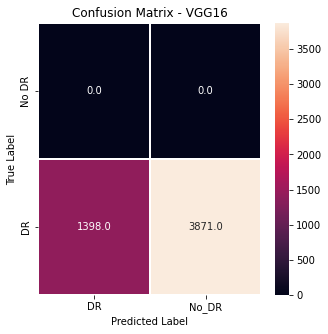

In [20]:
confusion_mtx = confusion_matrix(y_pred_vgg, test_batches.classes)
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
patient_labels = ['No DR','DR']
ax.yaxis.set_ticklabels(patient_labels)
plt.title("Confusion Matrix - VGG16")
plt.show()

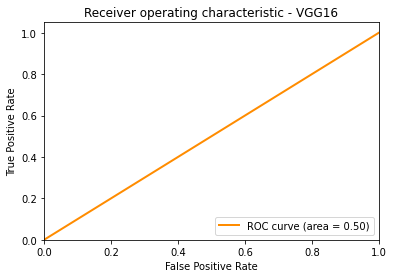

In [21]:
fpr = 0
tpr = 0
roc_auc = 0
fpr, tpr, _ = roc_curve(test_batches.classes, y_pred_vgg)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic - VGG16")
plt.legend(loc="lower right")
plt.show()

In [22]:
print(classification_report(test_batches.classes, y_pred_vgg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1398
           1       0.73      1.00      0.85      3871

    accuracy                           0.73      5269
   macro avg       0.37      0.50      0.42      5269
weighted avg       0.54      0.73      0.62      5269



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
loss, acc = vgg16_model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc) 


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


165/165 [==============================] - 14s 87ms/step - loss: 0.5558 - acc: 0.7347
Accuracy:  0.7346745133399963


In [24]:
print('VGG16 Cohen Kappas Value: ' + str(cohen_kappa_score(test_batches.classes, y_pred, labels=None, weights=None)))

VGG16 Cohen Kappas Value: 0.08379401699348599


### AlexNet

In [25]:
# Building the model

alex_net_model = tf.keras.Sequential([
  layers.Conv2D(96,  11, strides=4, padding="same", input_shape=(224,224,3), activation = 'relu'),
 layers.BatchNormalization(),
 layers.MaxPool2D(3, strides=2),
  layers.Conv2D(256, 5, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPool2D(3, strides=2),
 layers.Conv2D(384, 3, strides=1, padding='same', activation='relu'),
 layers.Conv2D(384, 3, strides=1, padding='same', activation='relu'),
 layers.Conv2D(256, 3, strides=1, padding='same', activation='relu'),
 layers.BatchNormalization(),
 layers.MaxPool2D(3, strides=2),
 layers.Flatten(),
 layers.Dense(4096, activation='relu'),
 layers.Dense(4096, activation='relu'),
 layers.Dense(2, activation='softmax'),
])

alex_net_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = alex_net_model.fit(train_batches,
                    epochs=10,
                    validation_data=val_batches)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
769/769 [==============================] - 76s 97ms/step - loss: 0.6040 - acc: 0.7188 - val_loss: 0.5654 - val_acc: 0.7318
Epoch 2/10
769/769 [==============================] - 73s 94ms/step - loss: 0.5640 - acc: 0.7357 - val_loss: 0.5575 - val_acc: 0.7330
Epoch 3/10
769/769 [==============================] - 72s 94ms/step - loss: 0.5530 - acc: 0.7365 - val_loss: 0.5672 - val_acc: 0.7318
Epoch 4/10
769/769 [==============================] - 74s 96ms/step - loss: 0.5437 - acc: 0.7422 - val_loss: 0.5606 - val_acc: 0.7339
Epoch 5/10
769/769 [==============================] - 74s 96ms/step - loss: 0.5330 - acc: 0.7467 - val_loss: 0.5626 - val_acc: 0.7307
Epoch 6/10
769/769 [==============================] - 77s 100ms/step - loss: 0.5238 - acc: 0.7541 - val_loss: 0.5514 - val_acc: 0.7425
Epoch 7/10
769/769 [==============================] - 74s 96ms/step - loss: 0.5068 - acc: 0.7608 - val_loss: 0.5587 - val_acc: 0.7339
Epoch 8/10
769/769 [==============================] - 74s 96m

In [26]:
alex_net_model.save('dissertation-alex.model')

In [27]:
Y_pred_alex=alex_net_model.predict(test_batches)
y_pred_alex = np.argmax(Y_pred_alex, axis=1)

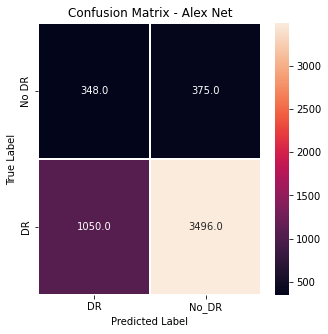

In [28]:
confusion_mtx = confusion_matrix(y_pred_alex, test_batches.classes)
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_batches.class_indices)
patient_labels = ['No DR','DR']
ax.yaxis.set_ticklabels(patient_labels)
plt.title("Confusion Matrix - Alex Net")
plt.show()

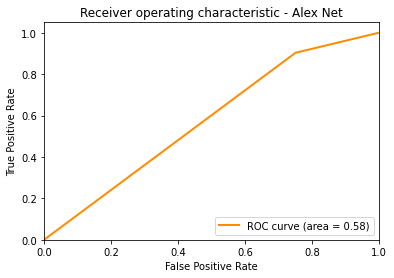

In [29]:
fpr = 0
tpr = 0
roc_auc = 0
fpr, tpr, _ = roc_curve(test_batches.classes, y_pred_alex)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic - Alex Net")
plt.legend(loc="lower right")
plt.show()

In [30]:
print(classification_report(test_batches.classes, y_pred_alex))

              precision    recall  f1-score   support

           0       0.48      0.25      0.33      1398
           1       0.77      0.90      0.83      3871

    accuracy                           0.73      5269
   macro avg       0.63      0.58      0.58      5269
weighted avg       0.69      0.73      0.70      5269



In [31]:
loss, acc = alex_net_model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc) 


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


165/165 [==============================] - 12s 74ms/step - loss: 0.5817 - acc: 0.7296
Accuracy:  0.7295501828193665


In [32]:
print('Alex Net Cohen Kappas Value: ' + str(cohen_kappa_score(test_batches.classes, y_pred, labels=None, weights=None)))

Alex Net Cohen Kappas Value: 0.08379401699348599
